# Network Analysis Project 
#### Building an Recommendation System from Bipartite Networks
---

*Ludek Cizinský (luci@itu.dk)*, *Louis Brandt (locb@itu.dk)*, *Lukas Rasocha (lukr@itu.dk)*, *Mika Senghaas (jsen@itu.dk)*, *Jacob Victor Enggaard Haahr (javh@itu.dk)*

Course Manager: *Michele Coscia*

Deadline: *22nd Decemeber 2021*

Last Modified: *28th September 2021*

## Assignment Description
---
You will have to deliver your project at the end of the course (deadline to be determined). You have to hand in a presentation (in PDF or Power Point format). It is mandatory to include the following information:

- Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).
- Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).
- A clear statement of your research question, the result of project phase #3.
- The analysis, results, and interpretation that allow you to answer your research question, the result of project phase #4.

You're free to include this in the order you prefer and to add any additional information you deem necessary, but these are the mandatory components.

The format of the oral is as follows: the students make a joint presentation followed by group questions. Subsequently the students are having individual examination with additional questions while the rest of the group is outside the room. The length of the oral will be 15 minutes X number of group members plus one -- for instance, a group of 6 will have 105 minutes ((6+1)*15). Which means you have 15 minutes of group exam plus 15 minutes of individual exam each.

## Environment Setup
---
This project uses Python libraries that are essential for the performed analysis. Make sure to have the dependencies listed in `requirements.txt` installed locally using the *Python Package Manager* `pip`. If installed, running the next code cell should install all relevant dependencies. Check documentation via the provided links:

- [*NetworkX* Documentation](https://networkx.org/documentation/stable/reference/index.html)

- [*NumPy* Quickstart](https://numpy.org/doc/stable/user/quickstart.html)
- [*Matplotlib* Documentation](https://matplotlib.org/stable/tutorials/introductory/usage.html)
- [*Pandas* Documentation](https://pandas.pydata.org/docs/)

### Libraries

In [118]:
%%capture
!pip install -r requirements.txt

In [120]:
# network representation and algorithms
import networkx as nx
from networkx.algorithms import bipartite
from pyvis.network import Network
from networkx import linalg as nxla


from matplotlib import pyplot as plt           # basic plotting
import seaborn as sns                          # advanced plotting
import numpy as np                             # for representing n-dimensional arrays
import scipy as sp                             # numerical computation
import pandas as pd                            # dataframes
from sklearn.linear_model import LinearRegression # Power fit



# python standard library
import json                                    # read/ write json
import re                                      # regex search 
import os                                      # os operations
import random                                  # randomness

### Flags

Flags are used to control the run flow of the notebook when executed at once. This is useful, to prevent operations that should only produce a result once, from running multiple times. 

In [121]:
# section flags
LOAD_DATA = True # Loads raw data for initial inspection
TRANSFORM_DATA = False # Transforms raw data into more suitable format (Load data needs to be on as well)
COMPUTE_PROJECTIONS = False
DO_BACKBONING = False

### Constants



In [122]:
PATH_TO = {}
PATH_TO['data'] = {}
PATH_TO['data']['raw'] = 'data/raw'
PATH_TO['data']['transformed'] = 'data/transformed'
PATH_TO['data']['projections'] = 'data/projections'
PATH_TO['data']['backboning'] = 'data/backboning'
PATH_TO['data']['figures'] = 'data/figures'

### Folder Structure

Create relevant folders to read from and write to, if not yet existent.

In [123]:
# iterate over path_to dict
DIRS = ['data/raw', 'data/transformed', 'visualisations', '']
# what folders do we need (?)
for dir in DIRS:
    # create if not existent
    pass

## #01 Loading and Inspecting Raw Data
---

In [124]:
if LOAD_DATA:
    data = pd.read_csv(f"{PATH_TO['data']['raw']}/data.txt", delimiter=":", names=["user_id", "repo_id"])
    repos = pd.read_csv(f"{PATH_TO['data']['raw']}/repos.txt", delimiter=":", names=["repo_id", "meta_info"])
    lang = pd.read_csv(f"{PATH_TO['data']['raw']}/lang.txt", delimiter=":", names=["repo_id", "meta_info"])

### `data.txt`

This is the main dataset.  Each line is of the format `<user_id>`:`<repo_id>`
which represents a user watching a repository.  There are 440,237 records
in this file, each a single `user_id` and a single `repository_id` seperated by a colon. This file, thus, represents the bipartite graph of users following repositories as an edge list. The data looks like this:

In [125]:
print(f"Size of data.txt: {data.shape}")
print(f"Number of Unique Users: {len(np.unique(data['user_id']))}")
print(f"Number of Unique Repos: {len(np.unique(data['repo_id']))}")

data.head()

Size of data.txt: (440237, 2)
Number of Unique Users: 56519
Number of Unique Repos: 120867


,user_id,repo_id
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5


### `repos.txt`

This file lists out the 120,867 unique repositories using their id (`repo_id`) that are used in the `data.txt`
set, providing the repository name, date it was created and (if applicable)
the repository id that it was forked off of.  The data looks like this:

In [126]:
print(f"Size of repo.txt: {repos.shape}")
print(f"ID's of data.txt and repos.txt match: {sum(np.unique(data['repo_id']) == np.unique(repos['repo_id'])) == 120867}")
print(f"No. of Repos with forking info: {sum(repos['meta_info'].apply(lambda x: len(x.split(','))) == 3)}")

repos.head()

Size of repo.txt: (120867, 2)
ID's of data.txt and repos.txt match: True
No. of Repos with forking info: 38954


,repo_id,meta_info
0,1,"richardc/perl-number-compare,2009-02-26"
1,2,"axiomsoftware/axiom-inspector,2009-05-09"
2,3,"rails/open_id_authentication,2008-05-29"
3,4,"brandonkelly/bk.fieldframe.ee_addon,2009-01-31"
4,5,"skinofstars/boxfire,2009-01-31"


### `lang.txt`

The last dataset included is the language breakdown data.  This lists  only contains 73,496 repositories, for which the language data was available. Each line of this file lists the repository id, then a comma delimited list of 
`<lang>`;`<lines>` entries containing each major language found and the number
of lines of code for that language in the project.  The data looks like this:

In [127]:
print(f"Size of repo.txt: {lang.shape}")

lang.head()

Size of repo.txt: (73496, 2)


,repo_id,meta_info
0,8213,"JavaScript;802,Ruby;395056"
1,24640,"Shell;173,Java;2580,Groovy;26623,JavaScript;13..."
2,41067,Ruby;52570
3,82135,Ruby;175049
4,16427,Perl;15008


## #02 Transforming Data
---

The goal of this section is to get the following two files:
- data.txt = edge list containing our bipartite network
- metadata.json = json file containing metadata about each repository within our bipartite network

###  Adding Class to Nodes in Edge List 

In the edge list `data.txt` the edges connecting a node of type *User* (from now referred to as $U$) to a node of type *Repository* (from now referred to as $R$) cannot be differentiated on each row. (e.g. 1:1 -> we need to denote that one on the left belongs to user and the other 1 to repository) To read in the graph object correctly at a later point, we therefore add correct labeling into that dataframe by adding `u` to user ids and `r` to repo ids.

In [128]:
if TRANSFORM_DATA:
    data["user_id"] = data["user_id"].apply(lambda x: "u" + str(x))
    data["repo_id"] = data["repo_id"].apply(lambda x: "r" + str(x))

### Create Metadata

Here we combine `repos.txt` and `lang.txt` into one json file where keys are `repo ids` and values are corresponding `metadata`. Note that `repos.txt` should have info about all repos in our network, however `lang.txt` has only info about a subset of repos.

In [129]:
if TRANSFORM_DATA:
    # save repo metadata in dictionary
    metadata = {}
    repo_lang_mismatches = [] # Includes IDs of repos present in lang.txt but not in repos.txt

    # save metadata from repos.txt
    for i in range(len(repos)):
        repo_id, meta_info = repos.iloc[i]

        # parse the meta info
        if len(meta_info.split(',')) == 2:
            repo_name, creation_date, forked_from_id = meta_info.split(',') + [None]
        else:
            # you had None here at index 2 as well (not intended?)
            repo_name, creation_date, forked_from_id = meta_info.split(',')

        # save to dict
        metadata[f"r{repo_id}"] = {
            "repo_name": repo_name,
            "creation_date": creation_date,
            "forked_from_id": forked_from_id
        }
    
    # save metadata from lang.txt
    for i in range(len(lang)):
        repo_id, lang_info = lang.iloc[i]
       
        # save it
        if f"r{repo_id}" in metadata.keys():
            metadata[f"r{repo_id}"]["languages"] = [l.split(';') for l in lang_info.split(',')]
        
        # It means that there is a repository in lang.txt which is not present in repos.txt
        else:
            repo_lang_mismatches.append(repo_id)

### Save Transformed Files

For faster access later, the following code cell saves the transformed network data and meta data into the directory `data/transformed`. 

In [130]:
if TRANSFORM_DATA:
    # save edge list
    data.to_csv(f"{PATH_TO['data']['transformed']}/data.txt", header=False, index=False)
    
    # Save mismatches
    with open(f"{PATH_TO['data']['transformed']}/mismatches.csv", "w") as fp:
        fp.write(",".join([str(repoid) for repoid in repo_lang_mismatches]))

    # save metadata as json
    with open(f"{PATH_TO['data']['transformed']}/metadata.json", "w") as fp:
        json.dump(metadata, fp)

## #03 Network Cleaning
---

### Solve problems with mismatches (repos.txt <> lang.txt)

We start by double checking that indeed intersection of set of available repos and set of mismatch repos is empty

In [131]:
# Load mismatches = repos present in lang.txt but not in repos.txt
with open(f"{PATH_TO['data']['transformed']}/mismatches.csv", "r") as fp:
    mismatches = fp.readlines()[0].split(',')

# Load all repos present
repos = pd.read_csv(f"{PATH_TO['data']['raw']}/repos.txt", delimiter=":", names=["repo_id", "meta_info"])

# Double check that indeed intersection of set of available repos and set of mismatch repos is empty
len(set(repos["repo_id"]) & set(mismatches)) == 0

True

According to the description repos in `data.txt` should be all present within `repos.txt`. In other words, difference between these two sets should be an empty set. Let's check this.

In [132]:
# Load data from data.txt
datatxt = pd.read_csv(f"{PATH_TO['data']['raw']}/data.txt", delimiter=":", names=["user_id", "repo_id"])

# Check the above mentioned assumption
len(set(datatxt["repo_id"]) - set(repos["repo_id"])) == 0

True

Given the above two tests, we can safely conclude that mismatched **repos can be ignored.**

### Solve problems nodes whose edges were randomly removed

`Description of the problem:`

I found out one important thing which we need to decide about. It is concerned with the stucture of our data. According to this website, the way the dataset was created was:
- They retrieved all repo watches from their database (each edge then represents one watch in our network). Github was created back in 2008, therefore back then they “only” had around 0.5 million watches in db
- From this set of watches, some of them were held back, i.e., removed from the dataset.
- We were then provided a dataset of watches except from those that were withheld and from dataset called test.txt we know which users were impacted by this transformation. In other words, these users (roughly. 5000) have only a subset of their watches.
- In total, there is around 56k users, and my question is to you what do we do with the 5k users about which we have incomplete information? (The reason why they withheld the watches is that the challenge of the contest was to predict these withheld watches…)

`Proposed solution:`

I think that it is reasonable to keep the affected users within the network and argue that we are working with a network which was adjusted by the approach described above, but most importantly, the above approach was random. In other words, the above approach for example did not focus on users which represent hubs. Another argument would be that this way, we do not lose information which we would have lost by dropping affected users.

## #04 Summarise Pre-Processed Bi-Partite Network
---

After having transformed the raw data in a format that is easily usable to be loaded as a graph object, we load our graph. We are using `networkX` - the standard library in Python for representation, visualisation and computation on graphs. 

In [133]:
# load graph
G = nx.read_edgelist(f"{PATH_TO['data']['transformed']}/data.txt", delimiter=",", comments='#', create_using=nx.Graph)

In [134]:
# load metadata
with open(f"{PATH_TO['data']['transformed']}/metadata.json", "r") as fp:
    metadata = json.load(fp)

# add metadata to graph nodes
for repo_id, vals in metadata.items():
    to_add = {repo_id: vals}
    nx.set_node_attributes(G, to_add, "metadata")

In [135]:
# Show a random node's attributes
G.nodes["r2"]["metadata"]

{'repo_name': 'axiomsoftware/axiom-inspector',
 'creation_date': '2009-05-09',
 'forked_from_id': None,
 'languages': [['JavaScript', '2940890']]}

### Fundamental information

Below, you can find fundamental information about our bi-partite network.

In [136]:
# Store fundamental properties within pandas DF
overview = pd.DataFrame(columns=["name", "is_bipartite", "is_directed", "is_weighted", "selfloops_#", "nodes_#", "edges_#", "density"])

# save important data to dict
G_info = dict()

# fundamental stats
G_info["name"] = "Github contest 2009"
G_info["number_of_users"] = len([node for node in G.nodes() if node[0] == 'u'])
G_info["number_of_repos"] = len([node for node in G.nodes() if node[0] == 'r'])
G_info["is_directed"] = nx.is_directed(G)
G_info["is_weighted"] = nx.is_weighted(G)
G_info["selfloops_#"] = nx.number_of_selfloops(G)
G_info["nodes_#"] = nx.number_of_nodes(G)
G_info["edges_#"] = nx.number_of_edges(G)
G_info["density"] = nx.density(G)
G_info["is_bipartite"] = bool(nx.is_bipartite(G))

# add it do the overview
overview = overview.append(G_info, ignore_index=True)
overview

,name,is_bipartite,is_directed,is_weighted,selfloops_#,nodes_#,edges_#,density,number_of_repos,number_of_users
0,Github contest 2009,True,False,False,0,177386,440237,0.000028,120867.0,56519.0


### Top 10 repositories

Below, we show 10 most popular repositories. Here are the interesting insights:
- Each repository is written in Ruby, it is also the leading language in terms number of lines of code
- The above perhaps corresponds to the fact that the top repository is rails which is a framework for web development for Ruby developers. Here is a relevant [article](https://syndicode.com/blog/why-is-ruby-still-our-choice-in-2020-2/) about Ruby popularity over time.
- In addition, Github is developed using Ruby on Rails, perhaps that is where the popularity comes from. According to [this](https://gitstar-ranking.com/rails) site, Rails ranks 65th as of today.
- Looking at other repositories, we can see that they correspond to web-development, e.g. authlogic or cucumber (platform for testing)
- *(feel free to add more here)*

In [137]:
repos_degree = sorted([(repo, G.degree(repo)) for repo in G.nodes() if repo[0] == 'r'], key=lambda x: x[1], reverse=True)[:10]
repo_info = {
    "name": [G.nodes[repo_tuple[0]]["metadata"]["repo_name"] for repo_tuple in repos_degree],
    "degree": [repo_tuple[1] for repo_tuple in repos_degree],
    "technology_stack": [G.nodes[repo_tuple[0]]["metadata"]["languages"] for repo_tuple in repos_degree]
}
top_10_repos = pd.DataFrame(repo_info)
top_10_repos

,name,degree,technology_stack
0,rails/rails,3675,"[[JavaScript, 2438], [Ruby, 5423161]]"
1,technoweenie/restful-authentication,1929,"[[Ruby, 140923]]"
2,mislav/will_paginate,1611,"[[Ruby, 90684]]"
3,joshuaclayton/blueprint-css,1565,"[[Ruby, 32998]]"
4,binarylogic/authlogic,1438,"[[Ruby, 236385]]"
5,thoughtbot/paperclip,1362,"[[Ruby, 153462]]"
6,aslakhellesoy/cucumber,1159,"[[C Sharp, 339], [Java, 355], [Ruby, 319537]]"
7,madrobby/scriptaculous,1136,"[[Ruby, 3893], [JavaScript, 40316]]"
8,dchelimsky/rspec,1100,"[[Ruby, 726592]]"
9,technoweenie/attachment_fu,1006,"[[Ruby, 132960]]"


### Most used programming languages

Below, we can see most used programming languages in terms of package development. Here are the notes/thoughts about the below result:
- we should be aware that this metric can be easily skewed by outliers, i.e., you can have one large repository which will contribute a lot

- C, Ruby, C++ as top 3 languages is not a surprise since nowadays C is still one of the most popular programming languages, with regards to Ruby, see the above section
- *(feel free to add more)*

In [138]:
# Save the usage in dict such that: key is repo_name and value is number of lines of code
lang_usage = dict()

# Fill lang_usage
for info in metadata.values():
    if "languages" in info:
        for lang_info in info["languages"]:
            lang_name, n_lines = lang_info
            if lang_name in lang_usage:
                lang_usage[lang_name] += int(n_lines)
            else:
                lang_usage[lang_name] = int(n_lines)

In [148]:
# Prepare the data for plotting
# * First fit it to the pd dataframe
langs = np.array(list(lang_usage.keys())).reshape(-1, 1)
n_lines = np.array(list(lang_usage.values()), dtype=int).reshape(-1, 1)
df_lang_usage = pd.DataFrame(np.concatenate((langs, n_lines), axis=1), columns = ["Lang", "# of lines"])
df_lang_usage['# of lines'] = df_lang_usage['# of lines'].astype('int64')

# * Second sorted by # of lines in descending order (largest first)
sorteddf = df_lang_usage.sort_values(["# of lines"], axis = 0, ascending=False)

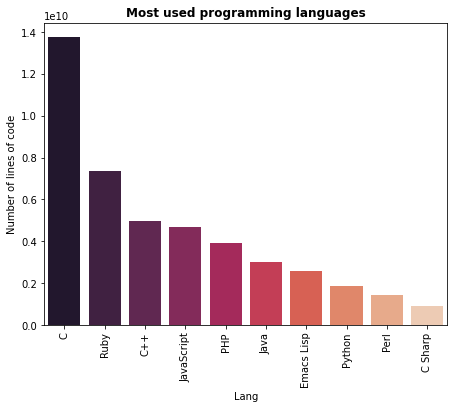

In [172]:
# Setup figure so you can plot inside it
fig = plt.figure(figsize=(7, 6)) # create figure object with a (width,height)
ax = fig.add_axes([0.1,0.2,0.8, 0.7]) # left, bottom, width, height (range 0 to 1)

# Plot the data
sns_plot = sns.barplot(x="Lang", y="# of lines", data=sorteddf[:10], ax=ax, palette="rocket");
ax.tick_params(axis='x', rotation=90);

# Add axis labels
ax.set_ylabel('Number of lines of code');
ax.set_title("Most used programming languages", weight="bold");

# Save plot
plt.savefig(f"{PATH_TO['data']['figures']}/most_used_lang.jpg")

### Degree distribution

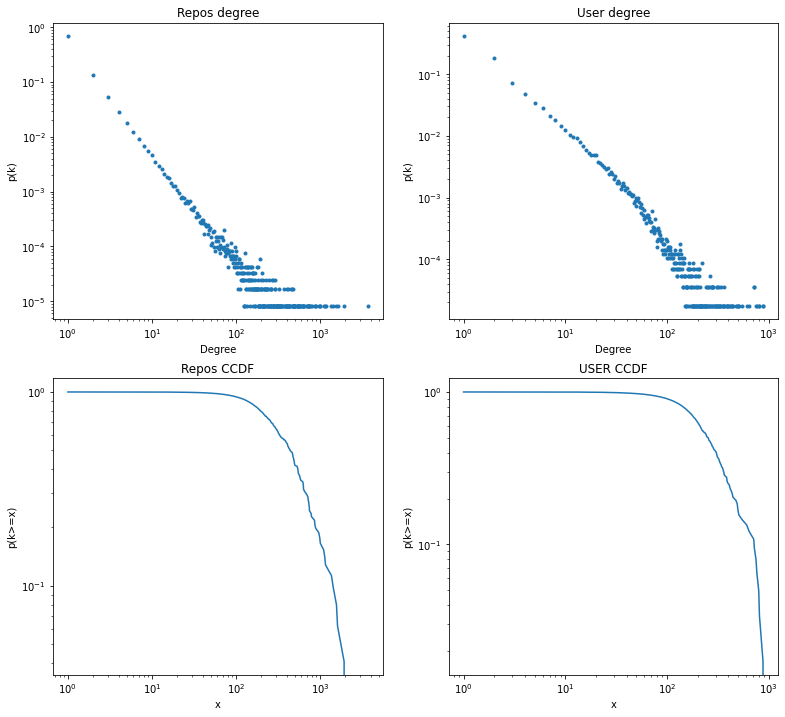

In [173]:
user_degree = [G.degree(n) for n in G.nodes() if n[0] == 'u']
repos_degree = [G.degree(n) for n in G.nodes() if n[0] == 'r']

user_degree, count_user_degree = np.unique(user_degree, return_counts=True)
repos_degree, count_repos_degree = np.unique(repos_degree, return_counts=True)

#Normalize
count_user_degree = count_user_degree / sum(count_user_degree)
count_repos_degree = count_repos_degree / sum(count_repos_degree)

#CDF
cdf_user_degree = user_degree.cumsum() / np.sum(user_degree)
cdf_repos_degree = repos_degree.cumsum() / np.sum(repos_degree)

#CCDF
ccdf_user_degree = 1-cdf_user_degree
ccdf_repos_degree = 1-cdf_repos_degree

#Plotting on a log-log scale
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 12))
axes[0][0].plot(repos_degree, count_repos_degree,'.')
axes[0][0].set_xlabel('Degree')
axes[0][0].set_title('Repos degree')
axes[0][0].set_ylabel('p(k)')
axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')


axes[0][1].plot(user_degree, count_user_degree,'.')
axes[0][1].set_title('User degree')
axes[0][1].set_xlabel('Degree')
axes[0][1].set_ylabel('p(k)')
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')

#CCDF
#Repos ccdf
axes[1][0].plot(repos_degree,ccdf_repos_degree)
axes[1][0].set_title('Repos CCDF')
axes[1][0].set_xlabel('x')
axes[1][0].set_ylabel('p(k>=x)')
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')

#User ccdf
axes[1][1].plot(user_degree,ccdf_user_degree)
axes[1][1].set_title('USER CCDF')
axes[1][1].set_xlabel('x')
axes[1][1].set_ylabel('p(k>=x)')
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
plt.show()

### Power law fit

- needs some tuning, trying to visualize the shifted power law?

In [ ]:
#Power law fit
x_data = [repos_degree,user_degree,repos_degree,user_degree]
y_data = [count_repos_degree,count_user_degree,ccdf_repos_degree,ccdf_user_degree]
titles = ['Repos degree','User degree','Repos CCDF','User CCDF']

#Transforming the scale and checking for 0 (where log is not defined)
# 0 comes from the CCDF because there is a 0 probability that x will be larger than the absolutely largest 
# degree in the network

x_trans_data = [np.where(i != 0, np.log10(i), 0) for i in x_data]
y_trans_data = [np.where(i != 0, np.log10(i), 0) for i in y_data]


fig, axes = plt.subplots(2,2, figsize=(10, 10), facecolor='w', edgecolor='k')
axes = axes.ravel()

for i in range(4):
    x,y = x_trans_data[i].reshape((-1,1)), y_trans_data[i]

    model = LinearRegression()
    model = model.fit(x,y)

    xs = np.linspace(np.min(x),np.max(x)+0.5,100)

    ys = model.predict(xs.reshape((-1,1)))

    axes[i].plot(x,y,'.')
    axes[i].plot(xs,ys)
    axes[i].set_title(titles[i])
    

## #05 Projections

In [ ]:
# Get V2, i.e., set of nodes representing repositories in acending sorted order by id
repos = [node for node in G.nodes() if node[0] == 'r']
users = [node for node in G.nodes() if node[0] == 'u']

# Show the start
print(repos[:5])
print(users[:5])

In [ ]:
# weight functions
def simple_weight(G, u, v):
    n_u, n_v = set(G[u]), set(G[v])
    # len of set of intersection
    return len(n_u & n_v) 

def jaccard(G, u, v):
    n_u, n_v = set(G[u]), set(G[v])
    # normalise len of set of intersectin by union
    return len(n_u & n_v) / len(n_u | n_v)


class VectorisedProjection:
    
    def __init__(self, G, repos, users):
        self.metric = None
        self.adj = nx.algorithms.bipartite.matrix.biadjacency_matrix(G, repos, users)
        self.repo_map = {repos[i]: i for i in range(len(repos))}

    def project(self, G, u, v):
        
        v_u = np.ravel(self.adj.getrow(0).todense().sum(axis=0))
        v_v = np.ravel(self.adj.getrow(1).todense().sum(axis=0))
        
        if self.metric == 'simple_weight':
            return np.sum((v_u + v_v) == 2)

        elif self.metric == 'euclidean':
            return sp.spatial.distance.euclidean(v_u, v_v)  

        elif self.metric == 'normalised_euclidean':
            return 1 / (np.sqrt(np.sum(np.power((v_u - v_v),2))) + 1)

        elif self.metric == 'pearson':
            return sp.stats.stats.pearsonr(v_u, v_v)[0] + 1

        elif self.metric == 'cosine':
            return 1 - sp.spatial.distance.cosine(v_u, v_v)

        else:
            print("Please specify one of the following metrics: ['simple_weight', 'euclidean', 'normalised_euclidean', 'pearson', 'cosine'].")

    
def hyperbolic(G, u, v):
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node])) - 1) for node in common])
    
def probs(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[u]))) for node in common])

def heats(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[v]))) for node in common])

def hybrid(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[u]))*len(set(G[v]))) for node in common])


weight_functions = [simple_weight, jaccard, VectorisedProjection, hyperbolic, probs, heats]
func_names = ["Simple weight", "Jaccard", "Vectorised projection", "Hyperbolic", "Probs", "Heats"]


# test cases
x = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])
y = np.array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1])

"""
print('simple_weight: ', np.sum((x + y) == 2))
print('euclidean: ', np.sqrt(np.sum(np.power((x - y),2))))
print('normalised euclidean: ', 1 / (np.sqrt(np.sum(np.power((x - y),2))) + 1))
print('cosine: ', 1 - sp.spatial.distance.cosine(x, y))
print('pearsn: ', sp.stats.stats.pearsonr(x, y)[0] + 1)
"""

u = 'r6'
v = 'r3'

for f, name in zip(weight_functions, func_names):
    if f == VectorisedProjection:
        f = VectorisedProjection(G, repos, users)
        for metric in ['simple_weight', 'euclidean', 'normalised_euclidean', 'pearson', 'cosine']:
            f.metric = metric
            print(f"{name} ({metric}): {f.project(G, u, v)}")
    else: 
        print(f"{name}: {f(G, u, v)}")

#### Performance benchmark

In [ ]:
# Default benchmark, at this pace, it will compute within 10 min
# Simple weight projection
%timeit -n 2000 simple_weight(G, "r1", "r2")

In [ ]:
# Initiate second method for projection, this time using pearson correlation of two vectors to measure edge weight
vp = VectorisedProjection(G, repos, users)
vp.metric = "pearson"

# Run the test -  we see that the ratio with the previous method is: 690/2.93 ~ 235x, i.e., 235x more time (~40 h)
%timeit -n 2000 vp.project(G, "r1", "r2")

#### Computation of projections

In [ ]:
if COMPUTE_PROJECTIONS:
    weight_functions = [simple_weight, jaccard, VectorisedProjection, hyperbolic, probs, heats]
    func_names = ["simple_weight", "jaccard", "vectorised_projection", "hyperbolic", "probs", "heats"]
    for f, name in zip(weight_functions, func_names):
        print(f"Currently working on: {name}")
        
        # Vectorised projections only
        if f == VectorisedProjection:
            
            # Takes too long, therefore continue
            continue
            
            # This will not be executed because of the continue
            f = VectorisedProjection()
            for metric in ['cosine', 'euclidean', 'normalised_euclidean', 'pearson']:
                f.metric = metric
                print(f"\n- {metric}")
                try:
                    projected = bipartite.generic_weighted_projected_graph(G, nodes=repos, weight_function=f.project)
                    nx.readwrite.gpickle.write_gpickle(projected, f"{PATH_TO['data']['projections']}/{name}_{metric}.pickle")
                except Exception as e:
                    print(f"Function: {name}_{metric} - failed because:")
                    print(e)
                    print("-"*10)
        
        # The rest of projections
        else: 
            try:
                projected = bipartite.generic_weighted_projected_graph(G, nodes=repos, weight_function=f)
                nx.readwrite.gpickle.write_gpickle(projected, f"{PATH_TO['data']['projections']}/{name}.pickle")
            except Exception as e:
                print(f"Function: {name} - failed because")
                print(e)
                print("-"*10)
        print()

## Load testing graph to check simple computations

In [ ]:
G_test = nx.path_graph(3)
G_test.add_edge(2, 3, weight=5)
G_test.add_edge(0, 1, weight=2)
G_test.add_edge(1, 2, weight=4)
G_test.edges.data("weight")

In [ ]:
A = nx.linalg.graphmatrix.adjacency_matrix(G_test)

In [ ]:
A*1/A.sum(axis = 1)

In [ ]:
A / A.sum(axis = 1)

## #06 Network backboning

Let's start with simple inspection of edge weight distribution. Below, you can see the first problem associated with using naive approach, i.e., to just get rid of nodes under certain nodes. The problem is broad weight distribution. (p. 333)

In [ ]:
from collections import Counter

In [ ]:
weights = Counter([w for n1, n2, w in G_simple.edges.data("weight")])

In [ ]:
# Plot the distribution
plt.loglog(weights.keys(), weights.values(), 'o', alpha=0.5);
plt.title("Edge weight distribution")
plt.xlabel("Edge weight");
plt.ylabel("# of edges");

I will now import a library provided by Michele on his web, which implements all the backboning techniques.

In [ ]:
from scripts import backboning

In order to be able to use the library, you need to provide in the specific format:
- edge list
- header must have columns src, trg, weight
- should be tab separated
- In case of undirected network, the edges have to be present in both directions with the same weights, or set triangular_input to True.

With this in mind, I therefore saved our projections in this format. Note that by using edge list format, we lose nodes which are not connected to any other node. (We should mention this within our presentation)

In [ ]:
which_projection = "simple_weight"

In [ ]:
G_projection = nx.readwrite.gpickle.read_gpickle(
    f"{PATH_TO['data']['projections']}/pickle_format/{which_projection}.pickle"
)

In [ ]:
table, nnodes, nnedges = backboning.read(f"{PATH_TO['data']['projections']}/edge_list_format/{which_projection}.edges",
                                         "weight",
                                         triangular_input=True,
                                         undirected=True,
                                         consider_self_loops=False)

Now, that we have loaded the data in the proper format, we can do the network backboning. I chose the below two methods because they are computaionally viable. For instance Double stochastic method was not viable since we were not able to reach convergence. As Michele wrote in the book, this is likely because our network is sparse. The other methods are very computationally intensive (we can try and see if it works, but I doubt it will run in reasonable time).

In [ ]:
if DO_BACKBONING:
    
    # Compute backboning measures and save it
    # * Disparity filter: node centered approach
    df_table = backboning.disparity_filter(table, undirected=True, return_self_loops=False)
    df_table.to_csv(f"{PATH_TO['data']['backboning']}/df_table_{which_projection}.csv", index=False)
    
    # * Noise corrected filter: edge centered approach
    nc_table = backboning.noise_corrected(table, undirected=True, return_self_loops=False)
    nc_table.to_csv(f"{PATH_TO['data']['backboning']}/nc_table_{which_projection}.csv", index=False)

**Load computed tables** if needed:

In [ ]:
if not DO_BACKBONING:
    df_table = pd.read_csv(f"{PATH_TO['data']['backboning']}/df_table_{which_projection}.csv")
    nc_table = pd.read_csv(f"{PATH_TO['data']['backboning']}/nc_table_{which_projection}.csv")

As a next step, we should figure how to use computed scores, i.e., which threshold to choose to filter out irrelevant edges.

In [ ]:
SIGNIF_THRS = 0.55

And finally, we can obtain valid set of edges as follows:

In [ ]:
df_table_reduced = backboning.thresholding(df_table, SIGNIF_THRS)
nc_table_reduced = backboning.thresholding(nc_table, SIGNIF_THRS)

At this point, we have a valid set of edges. As a next step, we should create a networkX graph object so we can further work with it. We should do so as follows:
- Add first all relevant edges which we just computed
- Get set of nodes from this network and them get difference with set of nodes which were in original projected network. This way, we will keep all original nodes from projected network, however, we will only have relevant edges in this new network.

In [ ]:
which_table = nc_table_reduced

In [ ]:
G_df = nx.convert_matrix.from_pandas_edgelist(which_table, 'src', 'trg', ['nij'])

In [ ]:
difference = set(G_projection.nodes) - set(G_df.nodes)
G_df.add_nodes_from(difference)

In [ ]:
len(difference)

Great, now we have a backboned graph, however, it would be interesting to actually see number of connected components within our graph.

In [ ]:
nx.algorithms.components.number_connected_components(G_df)

In [ ]:
plt.hist(nc_table["score"]);